In [1]:
#importamos las librerias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold

#modelos
import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor

#metricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


In [2]:
data = pd.read_excel('house_data.xlsx') #importamos la data

### 1. Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que puedan afectar la calidad del modelo, si los hay.

In [3]:
#creamos una tabla con informacion sobre la data y su calidad (tipos de datos, cantidad de valores unicos, cantidad de datos faltantes para cada columna)

result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores unicos', 'Valores faltantes'])

columnas = data.columns
data_types = data.dtypes.to_list()
unique_values = [data[columna].nunique() for columna in columnas]
missing_values = [data[columna].isnull().sum() for columna in columnas]

result_df['Columna'] = columnas
result_df['Tipo de dato'] = data_types
result_df['Valores unicos'] = unique_values
result_df['Valores faltantes'] = missing_values

print(pd.DataFrame(result_df))

          Columna Tipo de dato  Valores unicos  Valores faltantes
0              id        int64           21436                  0
1            date       object             372                  0
2           price        int64            4028                  0
3        bedrooms        int64              13                  0
4       bathrooms      float64              30                  0
5     sqft_living        int64            1038                  0
6        sqft_lot        int64            9782                  0
7          floors      float64               6                  0
8      waterfront        int64               2                  0
9            view        int64               5                  0
10      condition        int64               5                  0
11          grade        int64              12                  0
12     sqft_above        int64             946                  0
13  sqft_basement        int64             306                  0
14       y

- Hay columnas con datos categoricos y continuos, las columnas con pocos valores únicos definimos como categoricas.
- No hay datos faltantes

In [4]:
#eliminamos columnas irrelevantes para el analisis
data.drop(columns=['id', 'date', 'zipcode'], inplace=True)

**Creamos dos listas: una con nombres de columnas categorias y otra con columnas continuas.**

In [5]:
columnas_categoricas = ['bedrooms', 'bathrooms', 'waterfront','view', 'condition', 'grade', 'floors']

In [6]:
columnas_continuas = list(data.drop(columns=columnas_categoricas).columns)

### 2. Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas


In [7]:
#aplicamos value count a variables categoricas
for columna in columnas_categoricas:
    print(columna)
    print(data[columna].value_counts())

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
bathrooms
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64
waterfront
0    21450
1      163
Name: waterfront, dtype: int64
view
0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64
condition
3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64
grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: g

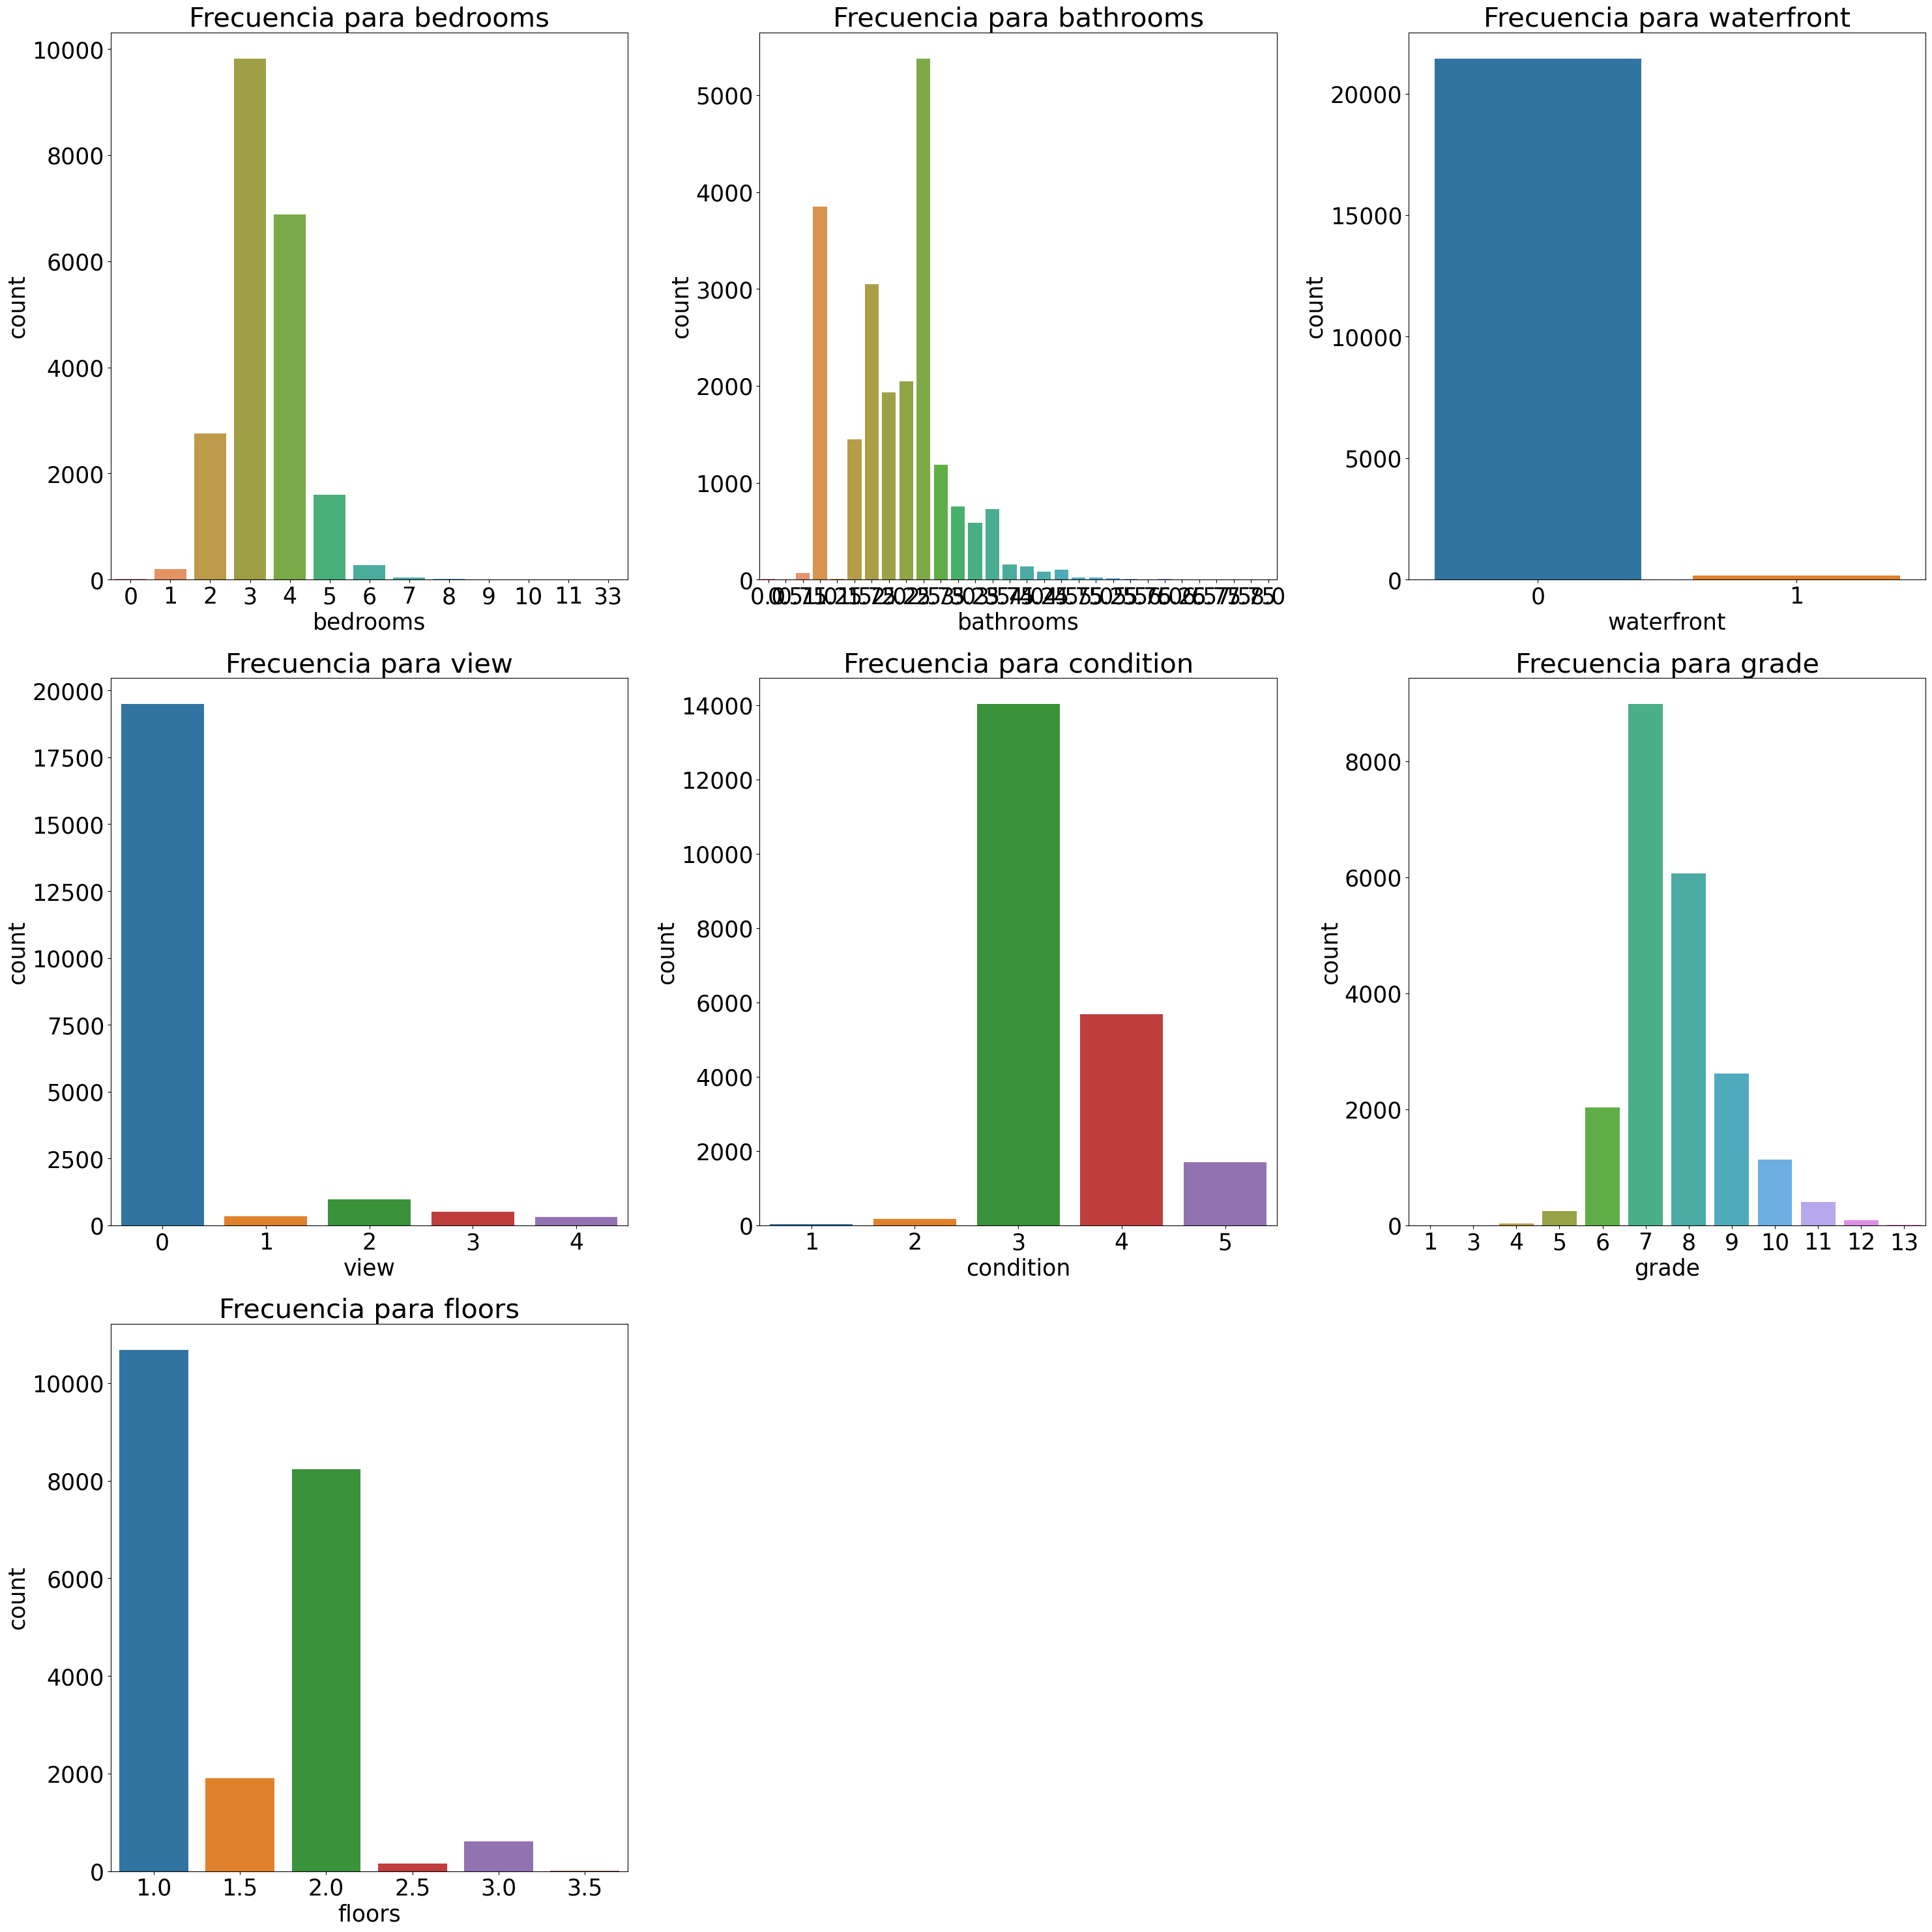

In [8]:
#graficamos las variables categoricas
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_categoricas):
    plt.subplot(3, 3, n+1)
    sns.countplot(x = data[i])
    plt.title('Frecuencia para {}'.format(i))
    plt.tight_layout(pad=0.8)

In [9]:
#la variable 'bathrooms' tiene muchas categorias. Para mejorar la calidad de data es mejor agrupar datos en categorias mas grandes.
data['bathrooms'] = data['bathrooms'].apply(lambda x: round(x,0))

In [10]:
data['bathrooms'].value_counts()

2.0    13851
1.0     3933
3.0     2527
4.0     1201
5.0       57
6.0       24
0.0       14
8.0        4
7.0        2
Name: bathrooms, dtype: int64

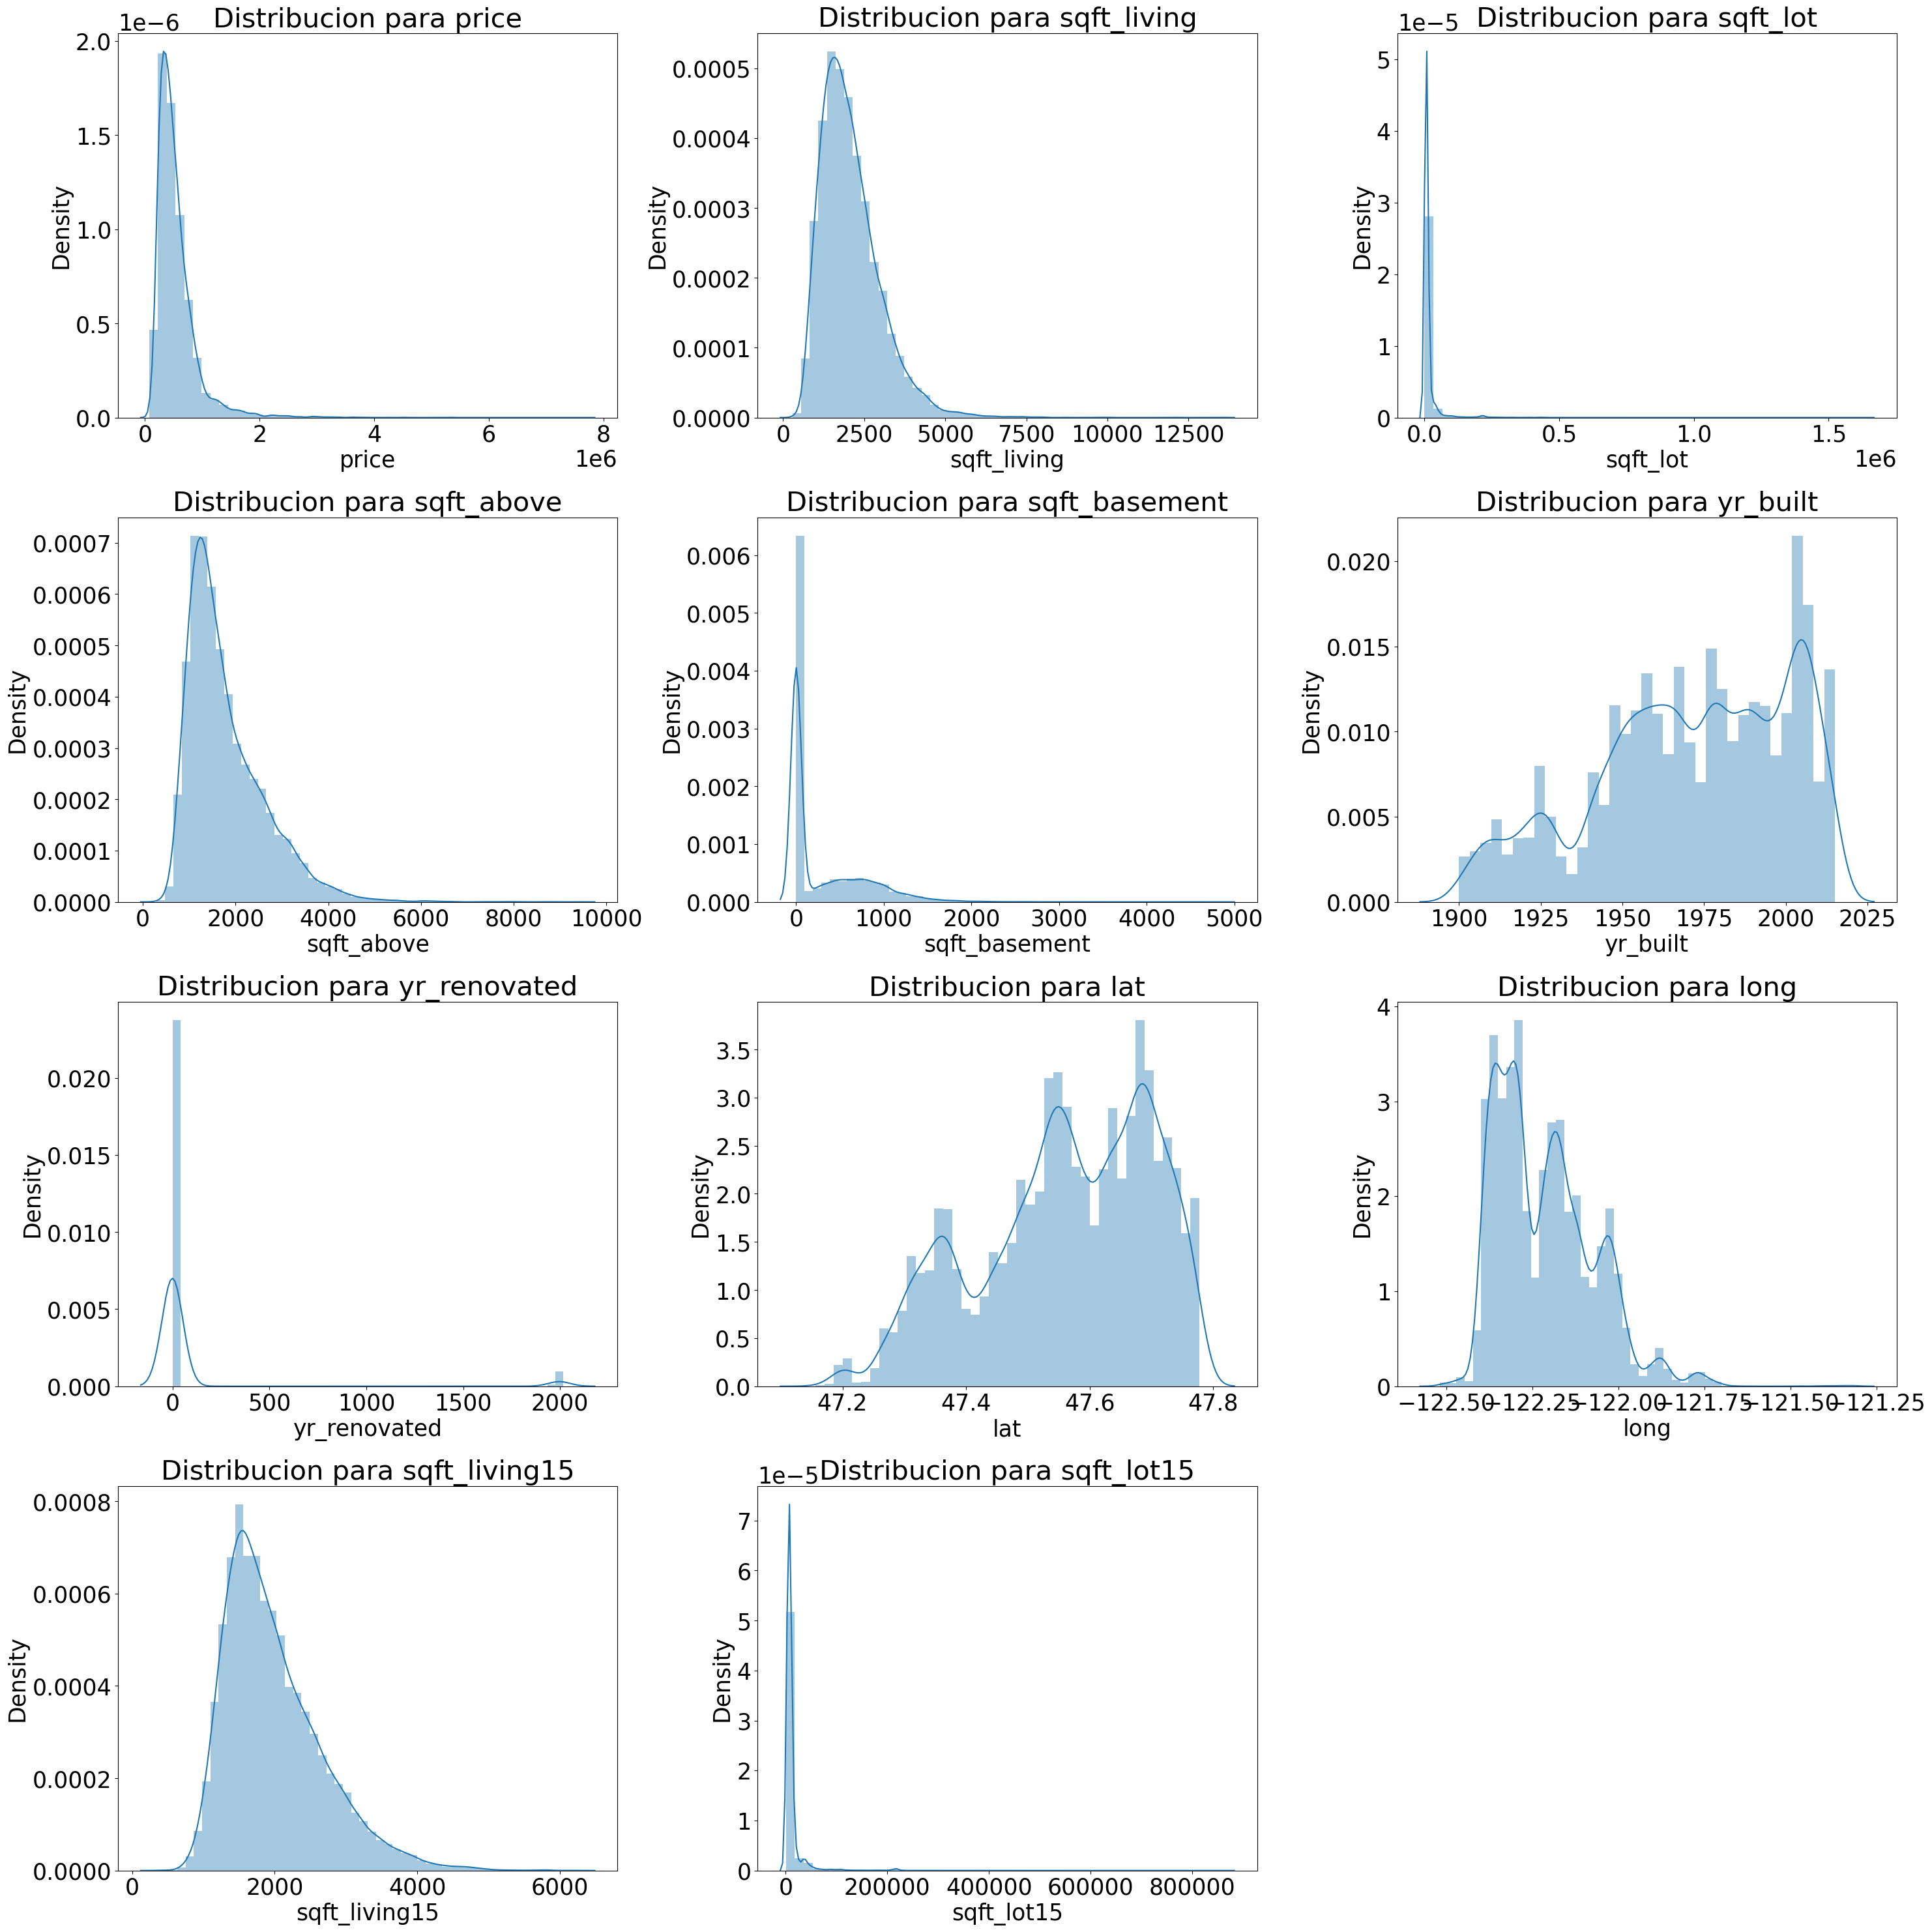

In [11]:
#graficamos la distribucion para las variables continuas
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30, 30))
for n, i in enumerate(columnas_continuas):
    plt.subplot(4, 3, n+1)
    sns.distplot(data[i])
    plt.title('Distribucion para {}'.format(i))
    plt.tight_layout(pad=0.8)
   

- Viendo las distribuciones podemos concluir que será necesario normalizar y escalar los datos.
- Las distribuciones son asimetricas
- La variable year renovates debe ser una variable categorica ya que 0 no es el año de renovación sino un indicador de que no han hecho renovacciones.

In [12]:
#convertimos la variable a una categorica, donde 0 significa 'no remodelaciones', 1 significa 'remodelaciones recientes'
data.loc[data['yr_renovated'] != 0] = 1
columnas_categoricas.append('yr_renovated')
columnas_continuas.remove('yr_renovated')

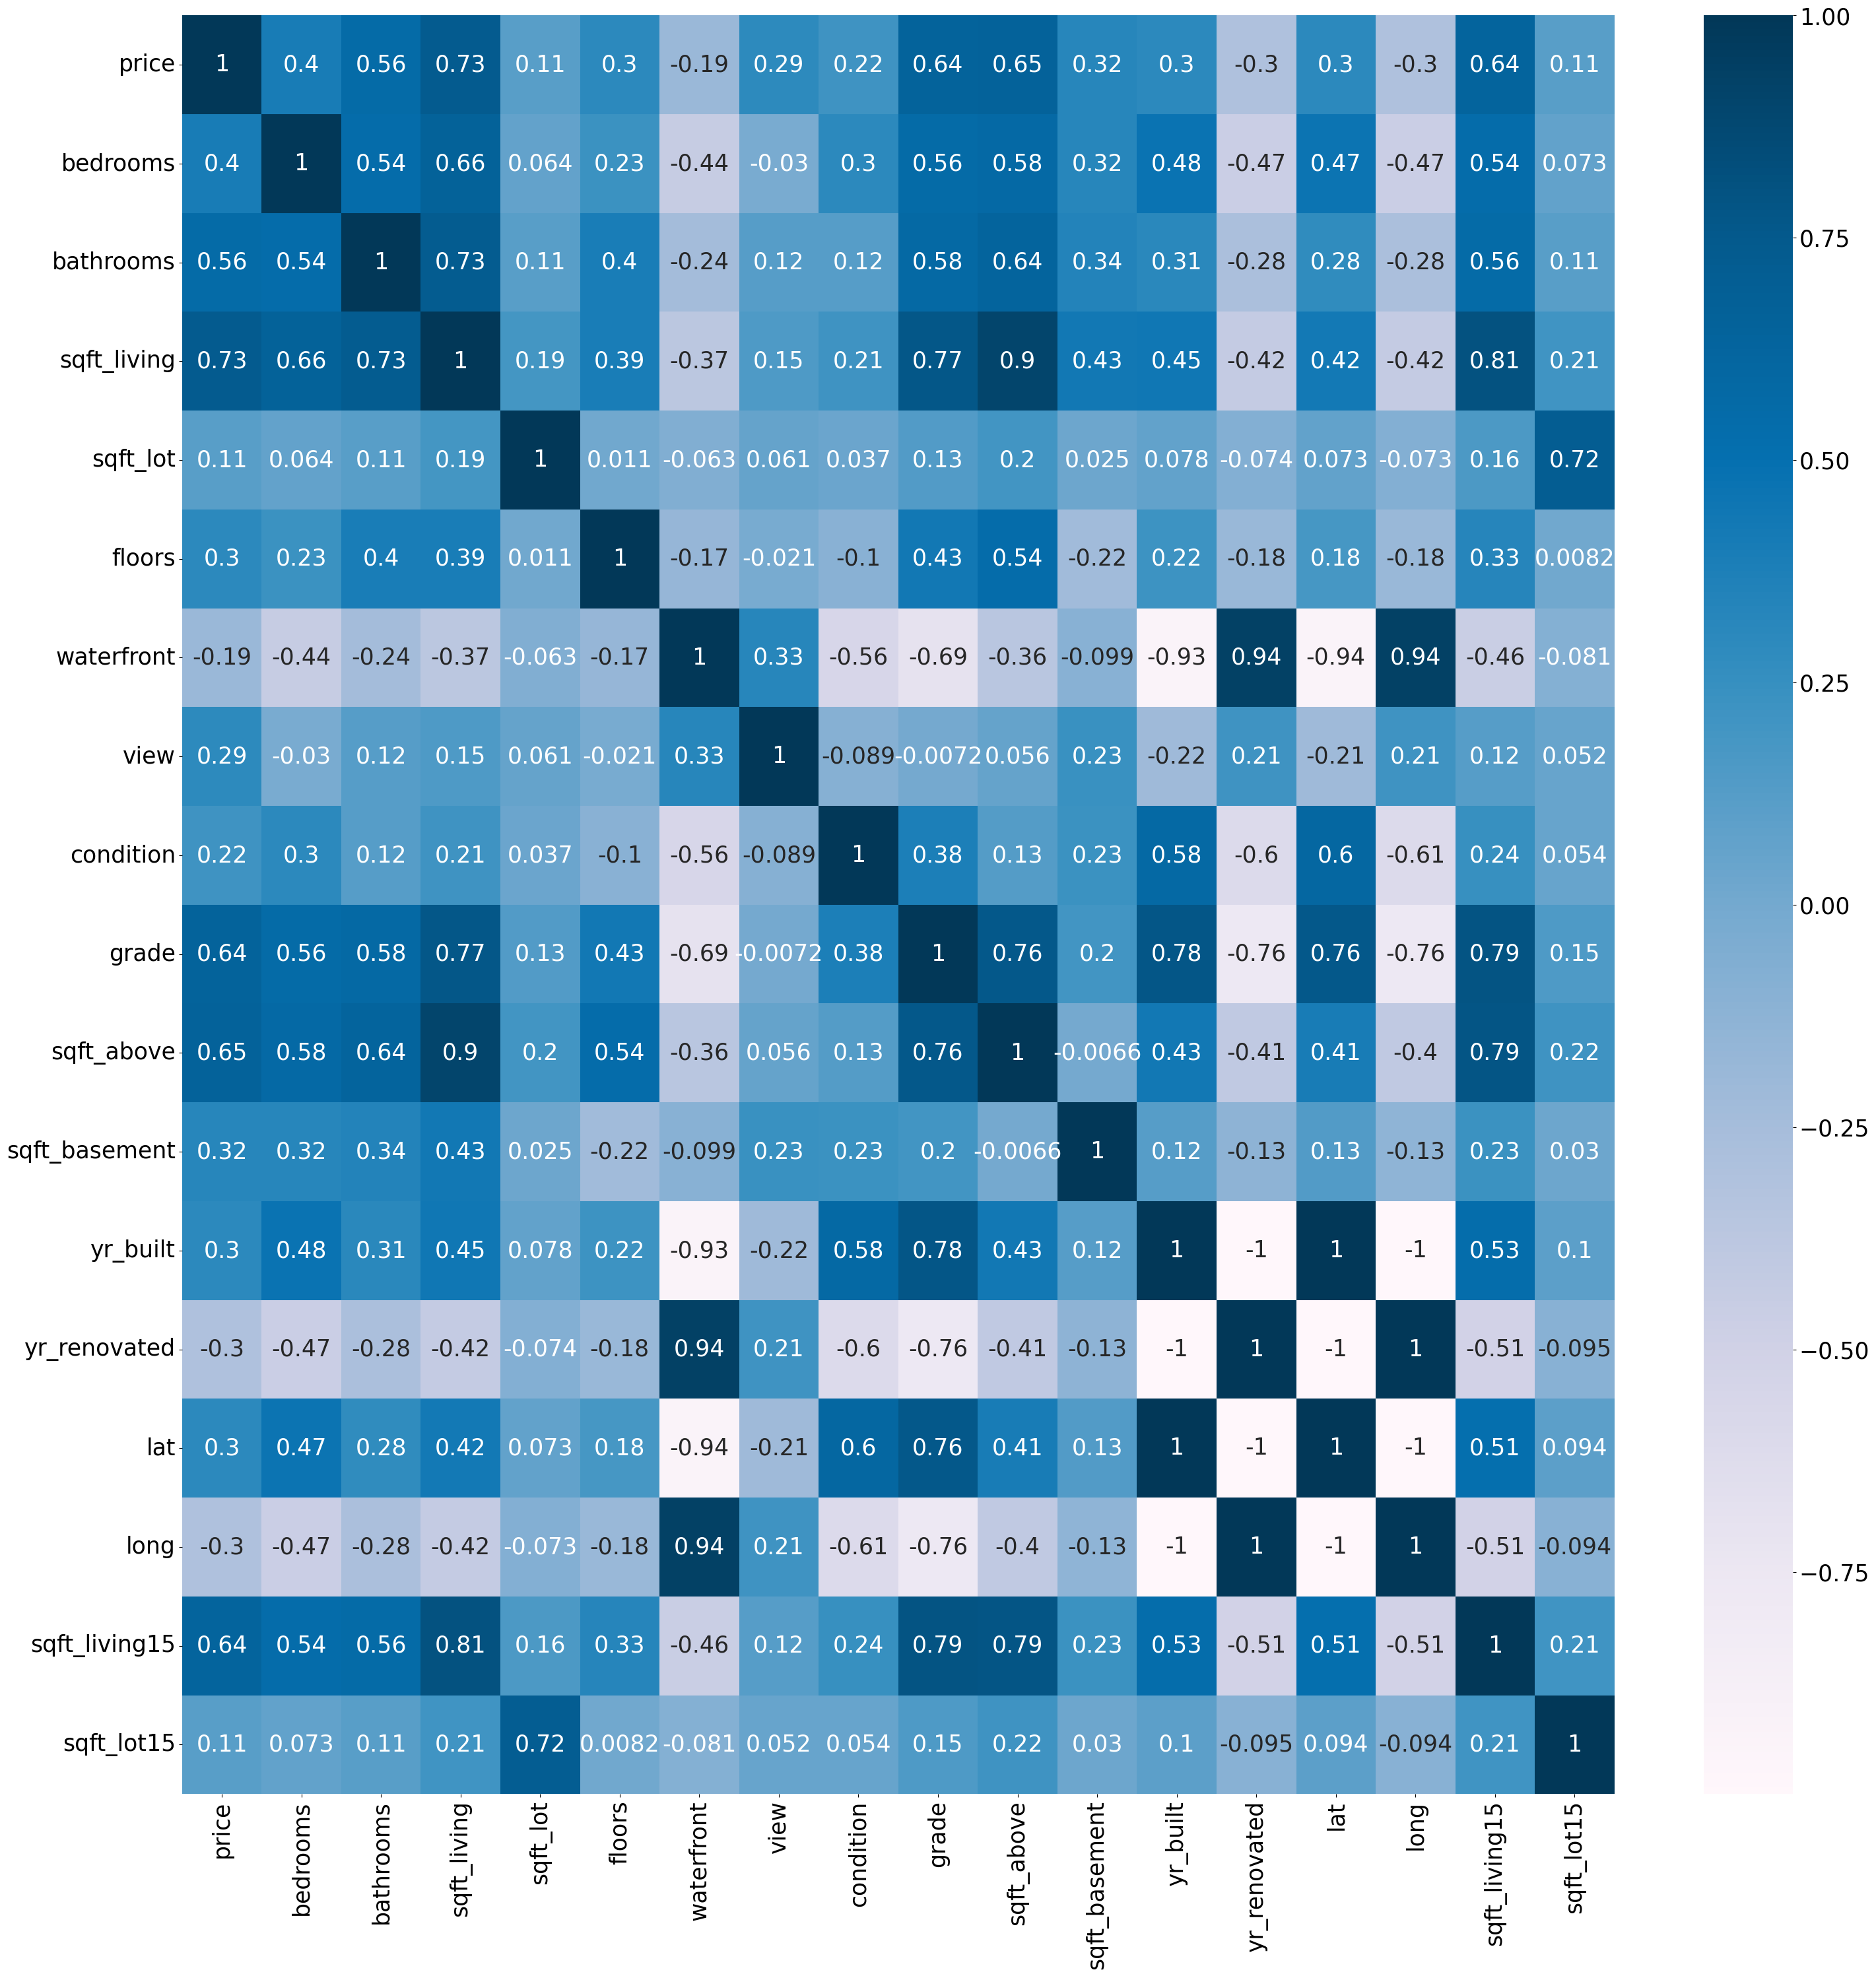

In [13]:
#creamos un heatmap con correlaciones entre las variables.
plt.figure(figsize=(35,35))
sns.heatmap(data.corr(), annot=True, cmap=plt.cm.PuBu)
plt.show()

- Varias columnas tienen alta correlacion entre ellas, para mejorar el rendimiento de los modelos es mejor eliminar una de cada para.

In [14]:
data.drop(columns = ['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], inplace= True) #primeras tres columnas tienen alta correlacion con sqft_living, la ultima - consqft_lot
columnas_categoricas.remove('grade')

<Axes: >

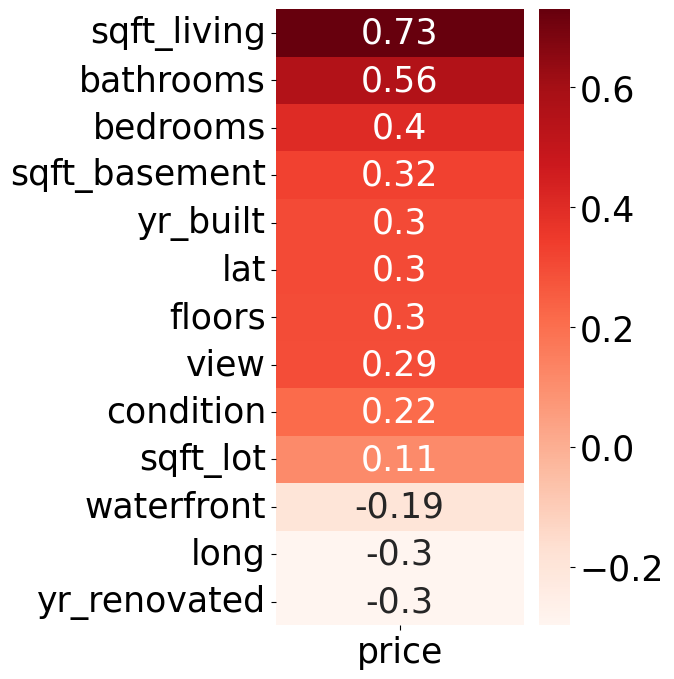

In [15]:
plt.figure(figsize=(4,8))
sns.heatmap(data.corr().loc[:, ['price']].sort_values('price', ascending= False).iloc[1:], cmap= 'Reds', annot= True)

### 3. Aplicar técnicas de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. Luego de ello, divide el conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada.

In [16]:
#Normalizamos y escalamos la data. aplicamos una transformacion logaritmica a la var precio
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data_scaled['price'] = np.log(data['price'])

In [17]:
#variables independientes y dependiente
X = data_scaled.drop(columns='price')
y = data_scaled['price']

In [18]:
#dividimos en dos sets: para entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Implementar modelos de regresión lineal con regularización, como Ridge, Lasso o Elastic Net y ajuste los hiper parámetros mostrando como se mueve los hiperparametros y el ajuste. Además, debes construir modelos de árboles de regresión para capturar relaciones no lineales y complejas entre las variables predictoras y el precio de las casas.

Creamos modelos Ridge y graficamos diferentes hiperparametros.

In [19]:
def cv_error(x_train, y_train, k, method = 'OLS', alpha = 1):

    # definimos los conjuntos de datos respectivos
    Xm, ym = x_train, y_train
    # creamos un objeto kFold para realizar la validación cruzada
    kf = KFold(n_splits=k)
    #Inicializamos rmse_cv a cero. Esta variable se utilizará para almacenar
    #la suma de los errores cuadráticos medios (RMSE) en cada iteración
    #de la validación cruzada.
    rmse_cv = 0
    # creamos una lista para almacenar los coeficientes
    coef_v = []

    # seleccionamos el método de regresión que se utilizará
    if method is 'OLS':
        method_type = lm.LinearRegression(fit_intercept=False)
    elif method is 'ridge':
        method_type = lm.Ridge(alpha=alpha, fit_intercept=False)
    elif method is 'lasso':
        method_type = lm.Lasso(alpha = alpha, fit_intercept=False)
    elif method is 'enet':
        method_type = lm.ElasticNet(alpha=alpha, fit_intercept=False)
    else:
        #indicamos error, si es el caso
        raise TypeError("Method argument is not valid")

    #para cada particion:
    for train_index, validation_index in kf.split(Xm):
        # instanciamos el modelo
        method_type = method_type
        #ajustamos segun el modelo
        method_type.fit(Xm.iloc[train_index,], ym.iloc[train_index,])
        # almacenamos los coeficientes
        coef_v.append(method_type.coef_)
        # creamos las prediciones
        yhat_validation = method_type.predict(Xm.iloc[validation_index])
        # recalculamos rmse
        rmse_cv += np.mean(np.power(np.array(yhat_validation) - np.array(ym.iloc[validation_index]), 2))

    return rmse_cv

In [20]:
names_regressors = X_train.columns # guardamos los nombres de los atributos

alphas = np.logspace(0, 7, base = 10) # generamos un vector con los valores de la norma
coefs_ridge = [] #lista para guardar parámetros
cv_err_ridge = [] #lista para guardar parámetros
model_ridge = Ridge(fit_intercept = True) # instanciamos el modelo
tol = 0.1 # determinamos el umbral de tolerancia

In [21]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con este valor
    model_ridge.set_params(alpha = a)
    model_ridge.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_ridge.append(model_ridge.coef_)
    # generamos su estimado de validación cruzada
    cv_err_estimates = cv_error(X_train, y_train, k = 10, method = 'ridge', alpha = a)
    cv_err_ridge.append(np.mean(cv_err_estimates)) # OJO: estamos guardando la media del error de cv para cada alpha

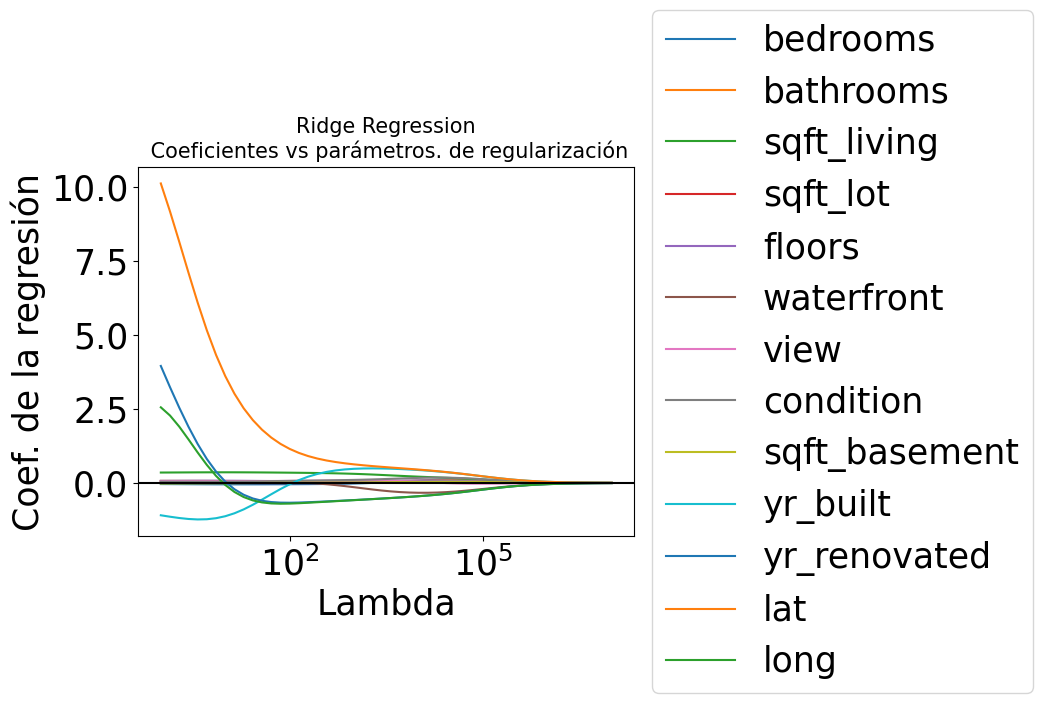

In [22]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Ridge Regression\n Coeficientes vs parámetros. de regularización",
size = 15)
plt.axhline(0, color='black')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

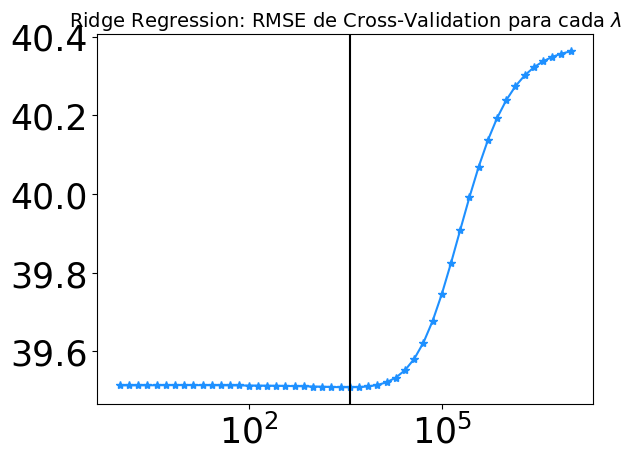

In [23]:
plt.plot(alphas, np.sqrt(cv_err_ridge),"*-", color='dodgerblue')
plt.axvline(alphas[np.argmin(np.sqrt(cv_err_ridge))], color='black', label='Minimo error')
plt.xscale("log")
plt.title("Ridge Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

- Lasso

In [24]:
names_regressors = X_train.columns # guardamos los nombres de los atributos
alphas = np.logspace(0, -3, base = 10) # generamos un vector con los valores de la norma
model_lasso = Lasso(fit_intercept = True) # instanciamos el modelo

coefs_lasso = []
cv_err_lasso = []

In [25]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con éste
    model_lasso.set_params(alpha = a)
    model_lasso.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_lasso.append(model_lasso.coef_)
    # generamos su estimado de validación cruzada
    cv_err_estimates = cv_error(X_train, y_train, k = 5, method = 'lasso', alpha = a)
    cv_err_lasso.append(np.mean(cv_err_estimates))

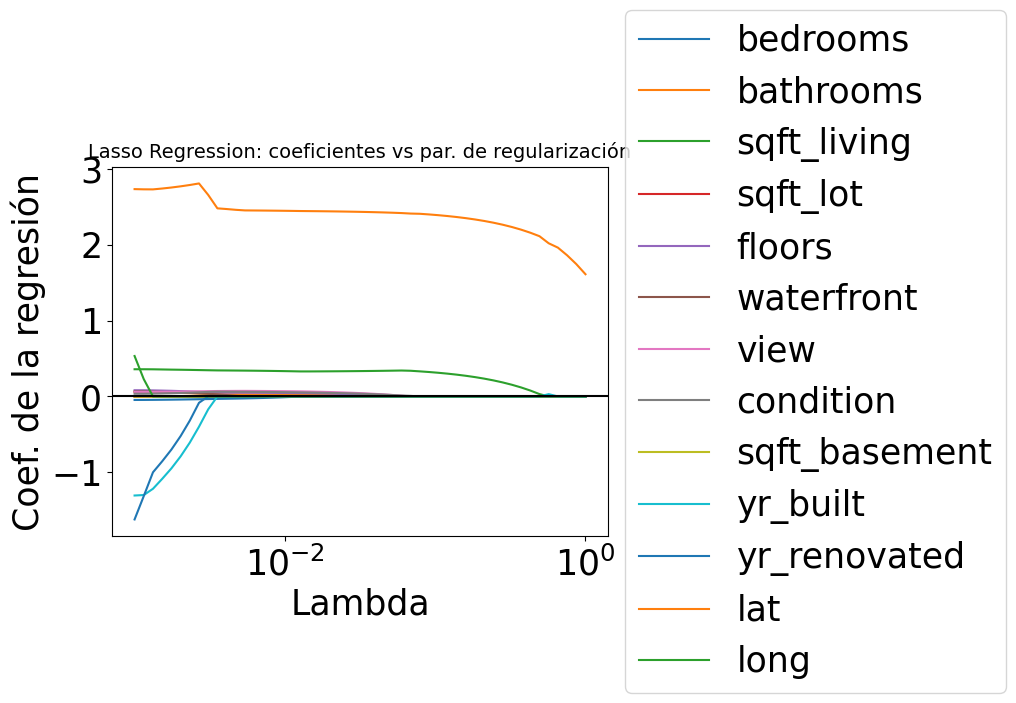

In [26]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_lasso).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Lasso Regression: coeficientes vs par. de regularización",
size = 14)
plt.axhline(0, color='black')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

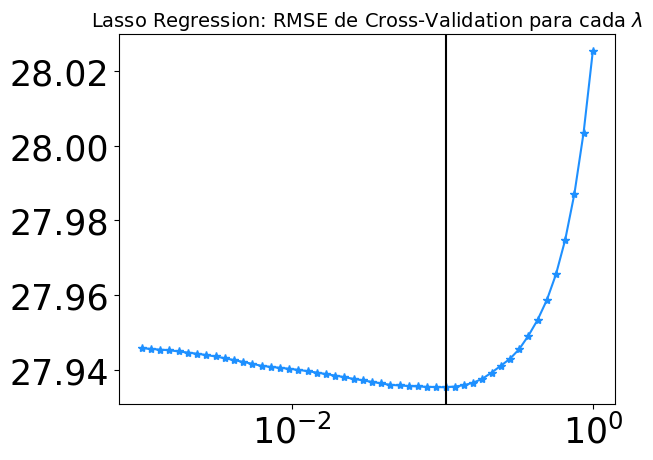

In [27]:
plt.plot(alphas, np.sqrt(cv_err_lasso),"*-", color='dodgerblue')
plt.axvline(alphas[np.argmin(np.sqrt(cv_err_lasso))], color='black', label='Minimo error')
plt.xscale("log")
plt.title("Lasso Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

### Usamos GridSearchCV para encontrar el mejor modelo.

In [28]:
#los modelos a comparar:

lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()
tree = DecisionTreeRegressor()

In [29]:
#hiperparámetros a ajustar:

lasso_param = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge_param = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
enet_param = {'alpha': [0.001, 0.01, 0.1, 1, 10],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
tree_param = {'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

In [30]:
#grid search para lasso
grid_search_lasso = GridSearchCV(lasso, lasso_param, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
lasso_best = grid_search_lasso.best_estimator_
lasso_params_best = grid_search_lasso.best_params_

#grid search para ridge
grid_search_ridge = GridSearchCV(ridge, ridge_param, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
ridge_best = grid_search_ridge.best_estimator_
ridge_params_best = grid_search_ridge.best_params_

#grid search para elastic net
grid_search_enet = GridSearchCV(enet, enet_param, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
enet_best = grid_search_enet.best_estimator_
enet_params_best = grid_search_enet.best_params_

#grid search para DecisionTreeRegressor
grid_search_tree = GridSearchCV(tree, tree_param, cv=5, scoring = 'neg_mean_squared_error').fit(X_train, y_train)
tree_best = grid_search_tree.best_estimator_
tree_params_best = grid_search_tree.best_params_

In [31]:
print('Lasso:')
print('Best Model:', grid_search_lasso.best_estimator_)
print('Best params:', grid_search_lasso.best_params_)
print('Ajuste:', -grid_search_lasso.best_score_)
print('\n')

print('Ridge:')
print('Best Model:', grid_search_ridge.best_estimator_)
print('Best params:', grid_search_ridge.best_params_)
print('Ajuste:', -grid_search_ridge.best_score_)
print('\n')

print('Elastic net:')
print('Best Model:', grid_search_enet.best_estimator_)
print('Best params:', grid_search_enet.best_params_)
print('Ajuste:', -grid_search_enet.best_score_)
print('\n')

print('Desicion tree regressor:')
print('Best Model:', grid_search_tree.best_estimator_)
print('Best params:', grid_search_tree.best_params_)
print('Ajuste:', -grid_search_tree.best_score_)
print('\n')

Lasso:
Best Model: Lasso(alpha=0.001)
Best params: {'alpha': 0.001}
Ajuste: 0.10124323187601329


Ridge:
Best Model: Ridge(alpha=0.001)
Best params: {'alpha': 0.001}
Ajuste: 0.0749429091491611


Elastic net:
Best Model: ElasticNet(alpha=0.001)
Best params: {'alpha': 0.001, 'l1_ratio': 0.5}
Ajuste: 0.10102104211171196


Desicion tree regressor:
Best Model: DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10)
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Ajuste: 0.04838273201176351




- El modelo de Decision tree regressor tiene el menor error quadrado medio, es el mejor modelo. 
- El modelo ridge tiene el menor EQM de los tres modelos de regreciones con regularizacion

### 5. Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R2), para medir el rendimiento del modelo y concluir sobre ellos.

In [32]:
#hacemos las prediciones y calculamos las metricas para todos los modelos


#Lasso
y_pred_lasso = lasso_best.predict(X_test)
print('Metricas Lasso')
print('R2: ', r2_score(y_pred_lasso, y_test))
print('MSE: ', mean_squared_error(y_pred_lasso, y_test))
print('MAPE: ', mean_absolute_percentage_error(y_pred_lasso, y_test), '\n')

#Ridge
y_pred_ridge = ridge_best.predict(X_test)
print('Metricas ridge')
print('R2: ', r2_score(y_pred_ridge, y_test))
print('MSE: ', mean_squared_error(y_pred_ridge, y_test))
print('MAPE: ', mean_absolute_percentage_error(y_pred_ridge, y_test), '\n')

#Elastic net
y_pred_enet = enet_best.predict(X_test)
print('Metricas elastic net')
print('R2: ', r2_score(y_pred_enet, y_test))
print('MSE: ', mean_squared_error(y_pred_enet, y_test))
print('MAPE: ', mean_absolute_percentage_error(y_pred_enet, y_test), '\n')

#Decision Tree Regressor
y_pred_tree = tree_best.predict(X_test)
print('Metricas Decision Tree Regressor')
print('R2: ', r2_score(y_pred_tree, y_test))
print('MSE: ', mean_squared_error(y_pred_tree, y_test))
print('MAPE: ', mean_absolute_percentage_error(y_pred_tree, y_test), '\n')

Metricas Lasso
R2:  0.9860155107517627
MSE:  0.10473364563313872
MAPE:  0.06429389964319805 

Metricas ridge
R2:  0.9894587523449623
MSE:  0.07927423332907665
MAPE:  0.0610173182946053 

Metricas elastic net
R2:  0.9860543873851088
MSE:  0.10442240401248136
MAPE:  0.06427585781063967 

Metricas Decision Tree Regressor
R2:  0.9935951895539483
MSE:  0.04839524369115074
MAPE:  0.01198333238396326 



- Los MSE y MAPE para modelos Lasso y Elastic Net son casi iguales.
- Los 4 modelos analizados tienen altos cofecientes de determinación, lo que significa que las variables independientes explican bien la variable objetiva.  
- A pesar de que los R2 son casi iguales para todos los modelos analizados, los MSE y MAPE del Decision Tree Regressor son significativamente más bajos que las mismas metricas de otros modelos.
- El analisis mas profundo confirma la conclusion: el modelo de Decision Tree Regressor tiene el mejor rendimiento.